In [108]:
import sys; sys.path.append('..')
import random
from dataclasses import dataclass
from datetime import datetime
from enum import Enum
from typing import Dict, List, Optional, Union

import emoji
from pydantic import BaseModel, Field

from brain.sdk import BrainClient

In [109]:
brain_client = BrainClient("http://127.0.0.1:8000")

In [33]:
@dataclass
class Memory:
    """Shared memory for storing intermediate reasoning results."""
    history: List[str] = None
    best_result: Optional[str] = None

# Initialize shared memory
memory = Memory(history=[])

# === SCHEMA FOR TASK REFINEMENT ===

class InitialTask(BaseModel):
    task: str = Field(..., description="The high-level task description.")
    context: Optional[str] = Field(None, description="Optional initial context for the task.")

class Refinement(BaseModel):
    refined_task: str = Field(..., description="A refined version of the high-level task.")
    confidence_score: float = Field(..., description="Confidence score for the refined task. (0.0 to 1.0)")

class FinalResult(BaseModel):
    result: str = Field(..., description="The final answer or solution to the reasoning problem.")
    confidence: float = Field(..., description="Confidence score for the final result. (0.0 to 1.0)")


In [35]:
@brain_client.reasoner(schema=Refinement)
def broad_exploration(task: InitialTask):
    """
    A reasoning agent that generates diverse hypotheses or solutions broadly for the initial task.
    """
    system_prompt = """You are an AI reasoning assistant tasked with broadly exploring the given task.
    Generate diverse hypotheses or ideas for solving the problem and provide a refined task description.
    Confidence score should reflect how promising the refined task is (0.0 to 1.0).
    """
    user_prompt = f"""
    Task: {task.task}
    Context: {task.context if task.context else 'No additional context provided.'}
    Please provide a refined task and confidence score.
    """
    return system_prompt, user_prompt

# Reasoner for specialized refinement
@brain_client.reasoner(schema=Refinement)
def specialized_refinement(task: Refinement):
    """
    A reasoning agent that deeply analyzes a refined task and further focuses on a specific aspect.
    """
    system_prompt = """You are an AI specializing in task refinement. Your goal is to deeply analyze the provided
    task, focus on its most critical aspects, and return a more specific task with a confidence score.
    """
    user_prompt = f"""
    Refined Task: {task.refined_task}
    Confidence Score: {task.confidence_score}
    Analyze and improve this task further for better reasoning.
    """
    return system_prompt, user_prompt

@brain_client.reasoner(schema=FinalResult)
def final_evaluator(task: Refinement):
    """
    Evaluates the refined task and produces the final result.
    """
    system_prompt = """You are an AI tasked with evaluating a refined task and producing a final answer.
    Consider all aspects of the task and ensure the answer is high-quality and well-reasoned.
    """
    user_prompt = f"""
    Refined Task: {task.refined_task}
    Confidence Score: {task.confidence_score}
    Provide a final answer and confidence score.
    """
    return system_prompt, user_prompt

#register reasoners
broad_exploration_id=broad_exploration.register()
specialized_refinement_id=specialized_refinement.register()
final_evaluator_id=final_evaluator.register()


In [81]:
def iterative_refinement(task: str, max_iterations: int = 5, verbose: bool = True):
    """
    Implements the iterative refinement process with agent substitution.
    """
    # Initialize the initial task
    initial_task = InitialTask(task=task)

    for iteration in range(max_iterations):
        if verbose:
            print(f"\n\U0001F680 Iteration {iteration + 1}: Starting task refinement \U0001F680")

        # Broad exploration phase
        if verbose:
            print(f"\U0001F4D6 Initial task: {initial_task.task}")
        broad_result = brain_client.use(broad_exploration_id)(task=initial_task)
        memory.history.append(f"Broad Exploration Result: {broad_result.refined_task}")

        if verbose:
            print(f"\U0001F50D Broad refinement: {broad_result.refined_task}")

        # Specialized refinement phase
        specialized_result = brain_client.use(specialized_refinement_id)(task=broad_result)
        memory.history.append(f"Specialized Refinement Result: {specialized_result.refined_task}")

        if verbose:
            print(f"\U0001F9E9 Specialized refinement: {specialized_result.refined_task}")

        # Evaluate confidence and decide whether to proceed
        if specialized_result.confidence_score > 0.85:
            final_result = brain_client.use(final_evaluator_id)(task=specialized_result)
            memory.best_result = final_result.result
            if verbose:
                print(f"\U0001F3C6 Final result achieved: {final_result.result}")
            return final_result

        if verbose:
            print(f"\U0001F504 Iteration {iteration + 1} completed, confidence below threshold. Refining again.")

    # If max iterations are reached without convergence
    if verbose:
        print("\u26A0\ufe0f Maximum iterations reached without achieving a high-confidence result.")
    return None

In [82]:
from emoji import emojize

class Subtask(BaseModel):
    question: str = Field(..., description="The specific subtask question.")
    iteration: int = Field(..., description="Current iteration number.")

class Solution(BaseModel):
    answer: str = Field(..., description="Answer to the subtask.")
    reasoning: str = Field(..., description="Detailed reasoning steps.")
    confidence: float = Field(..., description="Confidence level in the answer (0 to 1).")

class Feedback(BaseModel):
    feedback: str = Field(..., description="Feedback for further refinement.")
    is_valid: bool = Field(..., description="Whether the solution is valid for the original task.")

# %%
@brain_client.reasoner(schema=Subtask)
def diffusion_coordinator(task: str, iteration: int, max_iterations: int):
    """
    Orchestrates the iterative refinement process, generating more specific sub-tasks.
    """
    system_prompt = """You are a Diffusion Coordinator, orchestrating the task refinement process.
At each iteration, you generate a subtask that progressively becomes more specific, guiding towards the final answer.

Instructions:
- For early iterations, generalize the task to set a broad context.
- For later iterations, make the subtask more specific, focusing on the final answer.
- Ensure that over 'max_iterations', the task transitions from general to specific."""

    user_prompt = f"""Original Task: "{task}"
Current Iteration: {iteration}
Max Iterations: {max_iterations}

Generate the subtask for this iteration."""

    return system_prompt, user_prompt
diffusion_coordinator_id = diffusion_coordinator.register()

# %%
@brain_client.reasoner(schema=Subtask)
def generalizer_agent(subtask: Subtask, max_iterations: int):
    """
    Generalizes the subtask in early iterations to provide a broader context.
    """
    system_prompt = """You are a Generalizer Agent that broadens the subtask in early iterations to set up a broad reasoning context.

Instructions:
- If the iteration number is less than half of 'max_iterations', generalize the subtask.
- Otherwise, return the subtask as is."""

    user_prompt = f"""Subtask Question: "{subtask.question}"
Iteration: {subtask.iteration}
Max Iterations: {max_iterations}

Provide the generalized subtask."""

    return system_prompt, user_prompt
generalizer_agent_id = generalizer_agent.register()

# %%
@brain_client.reasoner(schema=Solution)
def solver_agent(subtask: Subtask):
    """
    Attempts to solve the given subtask, providing an answer and detailed reasoning.
    """
    system_prompt = """You are a Solver Agent that provides answers to specific subtasks.

Instructions:
- Provide a concise answer to the subtask.
- Include detailed reasoning steps.
- Assign a confidence score between 0 and 1."""

    user_prompt = f"""Subtask Question: "{subtask.question}"

Provide the answer, reasoning, and confidence score."""

    return system_prompt, user_prompt
solver_agent_id = solver_agent.register()

# %%
@brain_client.reasoner(schema=Solution)
def knowledge_integrator(solution: Solution):
    """
    Enhances the solution by integrating external knowledge.
    """
    system_prompt = """You are a Knowledge Integrator that enriches the solution with additional information.

Instructions:
- Integrate relevant external knowledge to improve the solution.
- Update the reasoning to reflect the new information."""

    user_prompt = f"""Current Answer: "{solution.answer}"
Current Reasoning: "{solution.reasoning}"

Enhance the solution with additional knowledge."""

    return system_prompt, user_prompt
knowledge_integrator_id = knowledge_integrator.register()

# %%
@brain_client.reasoner(schema=Feedback)
def feedback_analyzer(solution: Solution, task: str):
    """
    Analyzes the solution and provides feedback for further refinement.
    """
    system_prompt = """You are a Feedback Analyzer that assesses the solution against the original task.

Instructions:
- Determine if the solution adequately addresses the original task.
- If not, provide specific feedback for improvement.
- Indicate whether the solution is valid."""

    user_prompt = f"""Original Task: "{task}"
Solution Answer: "{solution.answer}"
Reasoning: "{solution.reasoning}"
Confidence: {solution.confidence}

Provide feedback and validity status."""

    return system_prompt, user_prompt
feedback_analyzer_id = feedback_analyzer.register()

# %%
@brain_client.reasoner(schema=Feedback)
def validator_agent(feedback: Feedback):
    """
    Validates the feedback and decides whether to continue or stop.
    """
    system_prompt = """You are a Validator Agent that decides whether to accept the solution or request further refinement.

Instructions:
- If the solution is valid, confirm acceptance.
- If not, recommend continuing the iterations."""

    user_prompt = f"""Feedback: "{feedback.feedback}"
Is Valid: {feedback.is_valid}

Decide whether to accept the solution or continue."""

    return system_prompt, user_prompt
validator_agent_id = validator_agent.register()

# %%
from emoji import emojize

@brain_client.multi_agent
def dynamic_diffusive_reasoning(task: str, max_iterations: int = 5, verbose: bool = True) -> str:
    """
    Multi-agent system that iteratively refines and solves a task with dynamic diffusive reasoning.
    """
    for iteration in range(1, max_iterations + 1):
        if verbose:
            print(emojize(f"\n:hourglass_not_done: Iteration {iteration}/{max_iterations}"))

        # Step 1: Diffusion Coordinator generates subtask
        subtask = brain_client.use(diffusion_coordinator_id)(task=task, iteration=iteration, max_iterations=max_iterations)
        if verbose:
            print(emojize(f":bullseye: Diffusion Coordinator generated subtask:\n{subtask.question}"))

        # Step 2: Generalizer Agent processes subtask
        subtask = brain_client.use(generalizer_agent_id)(subtask=subtask, max_iterations=max_iterations)
        if verbose:
            print(emojize(f":light_bulb: Generalizer Agent updated subtask:\n{subtask.question}"))

        # Step 3: Solver Agent attempts to solve subtask
        solution = brain_client.use(solver_agent_id)(subtask=subtask)
        if verbose:
            print(emojize(f":magnifying_glass_tilted_right: Solver Agent provided solution:\nAnswer: {solution.answer}\nReasoning: {solution.reasoning}\nConfidence: {solution.confidence}"))

        # Step 4: Knowledge Integrator enhances the solution
        solution = brain_client.use(knowledge_integrator_id)(solution=solution)
        if verbose:
            print(emojize(f":books: Knowledge Integrator enhanced solution:\nAnswer: {solution.answer}\nReasoning: {solution.reasoning}"))

        # Step 5: Feedback Analyzer assesses the solution
        feedback = brain_client.use(feedback_analyzer_id)(solution=solution, task=task)
        if verbose:
            print(emojize(f":memo: Feedback Analyzer provided feedback:\n{feedback.feedback}\nIs Valid: {feedback.is_valid}"))

        # Step 6: Validator Agent decides whether to continue
        decision = brain_client.use(validator_agent_id)(feedback=feedback)
        if verbose:
            print(emojize(f":check_mark_button: Validator Agent decision:\n{decision.feedback}"))

        # Check if the solution is valid
        if feedback.is_valid:
            if verbose:
                print(emojize("\n:crown: Final Answer Reached!"))
            return solution.answer

        # Update task with feedback for next iteration
        task = feedback.feedback

    if verbose:
        print(emojize("\n:warning: Maximum iterations reached without convergence."))
    return "Failed to reach a final answer."

In [105]:
from typing import Optional
from pydantic import BaseModel, Field
from brain.sdk import BrainClient
from dataclasses import dataclass, field
from typing import List

# Define the schemas
class Subtask(BaseModel):
    question: str = Field(..., description="The generalized question at the current iteration.")
    generalizations: List[str] = Field(..., description="List of generalization steps.")

class Solution(BaseModel):
    answer: str = Field(..., description="Answer to the generalized question.")
    confidence: float = Field(..., description="Confidence in the answer (0 to 1).")

@dataclass
class IterationData:
    iteration: int
    generalizations: List[str]
    subtask: str
    solution: str
    confidence: float

@dataclass
class ReasoningResult:
    steps: List[IterationData] = field(default_factory=list)
    final_answer: str = ""

# Define the agents with detailed prompts

# Generalizer Agent
@brain_client.reasoner(schema=Subtask)
def generalizer_agent(original_task: str, previous_answer: Optional[str], n: int):
    """
    Generalizes the task n times, using the previous answer as context.
    """
    system_prompt = """You are a Generalizer Agent.
Your role is to generalize the given task to a higher level of abstraction.
At each generalization:
- Make the task more abstract.
- Use the previous answer as context to guide the generalization.
- Ensure the core essence of the task is maintained.
- Be concise and precise.

Instructions:
- Perform n generalizations of the original task.
- Return the final generalized task and the list of all generalizations.

Important:
- Avoid losing critical details of the task.
- Each generalization should build upon the previous one.
"""

    if previous_answer:
        user_prompt = f"""Original Task: "{original_task}"
Previous Answer: "{previous_answer}"
Number of Generalizations: {n}

Please generalize the task {n} times, using the previous answer as context.
Provide the final generalized task and list all generalizations."""
    else:
        user_prompt = f"""Original Task: "{original_task}"
Number of Generalizations: {n}

Please generalize the task {n} times.
Provide the final generalized task and list all generalizations."""

    return system_prompt, user_prompt

generalizer_agent_id = generalizer_agent.register()

# Solver Agent
@brain_client.reasoner(schema=Solution)
def solver_agent(task: str, previous_answer: Optional[str]):
    """
    Provides an answer to the given task, using previous answers as context.
    """
    system_prompt = """You are a Solver Agent.
Your role is to provide a comprehensive answer to the given task.
Use any previous answers as context to enhance your response.

Instructions:
- Provide a clear and thorough answer.
- Include logical reasoning.
- Assign a confidence score between 0 and 1.
- Ensure your answer addresses the task effectively.
- Be precise and avoid unnecessary details.

Important:
- Build upon the previous answer if available.
"""

    if previous_answer:
        user_prompt = f"""Task: "{task}"
Previous Answer: "{previous_answer}"

Please provide your answer with a confidence score between 0 and 1."""
    else:
        user_prompt = f"""Task: "{task}"

Please provide your answer with a confidence score between 0 and 1."""

    return system_prompt, user_prompt

solver_agent_id = solver_agent.register()

# Rephraser Agent
@brain_client.reasoner(schema=Subtask)
def rephraser_agent(original_task: str, previous_answer: str):
    """
    Rephrases the original task based on the previous answer.
    """
    system_prompt = """You are a Rephraser Agent.
Your role is to rephrase the original task based on the previous answer.

Instructions:
- Use the previous answer to inform the rephrasing.
- Ensure the rephrased task remains true to the original intent.
- Be concise and clear.

Important:
- The rephrased task should reflect any insights gained from the previous answer.
"""

    user_prompt = f"""Original Task: "{original_task}"
Previous Answer: "{previous_answer}"

Please rephrase the original task accordingly."""

    return system_prompt, user_prompt

rephraser_agent_id = rephraser_agent.register()

# The get_nth_general function
def get_nth_general(original_task: str, n: int, previous_answer: Optional[str]) -> Subtask:
    # Initialize the generalizations list
    generalizations = []
    current_task = original_task

    for i in range(n):
        # Use the Generalizer Agent to generalize the task one step at a time
        generalized_subtask = brain_client.use(generalizer_agent_id)(
            original_task=current_task,
            previous_answer=previous_answer,
            n=1
        )

        # Append the new generalization to the list
        generalizations.append(generalized_subtask.question)
        # Update the current task for the next generalization
        current_task = generalized_subtask.question
        # Update previous_answer for context (if applicable)
        previous_answer = previous_answer

    # Return the final generalized task and all generalizations
    return Subtask(question=current_task, generalizations=generalizations)

# The main multi-agent function
@brain_client.multi_agent
def dynamic_diffusive_reasoning(original_task: str, max_iterations: int = 5, verbose: bool = True) -> ReasoningResult:
    result = ReasoningResult()
    previous_answer = None

    for n in range(max_iterations, -1, -1):
        iteration = max_iterations - n + 1
        if verbose:
            print(f"\n🕒 Iteration {iteration}/{max_iterations+1} (Generalization Level: {n})")

        if n > 0:
            # Get the nth generalization
            subtask = get_nth_general(original_task, n, previous_answer)

            if verbose:
                print(f"🔄 Generalizations:")
                for gen_step, gen_task in enumerate(subtask.generalizations, 1):
                    print(f"  Step {gen_step}: {gen_task}")
                print(f"👉 Final Generalized Task: {subtask.question}")

            # Solve the generalized task
            solution = brain_client.use(solver_agent_id)(
                task=subtask.question,
                previous_answer=previous_answer
            )

            if verbose:
                print(f"💡 Solution: {solution.answer} (Confidence: {solution.confidence:.2f})")

            # Record the iteration data
            iteration_data = IterationData(
                iteration=iteration,
                generalizations=subtask.generalizations,
                subtask=subtask.question,
                solution=solution.answer,
                confidence=solution.confidence
            )
            result.steps.append(iteration_data)

            # Update previous_answer for the next iteration
            previous_answer = solution.answer

        else:
            # When n == 0, use the Rephraser Agent
            if verbose:
                print("\n🔄 Final Iteration: Rephrasing the original task based on previous answer")

            rephrased_subtask = brain_client.use(rephraser_agent_id)(
                original_task=original_task,
                previous_answer=previous_answer
            )

            if verbose:
                print(f"📝 Rephrased Task: {rephrased_subtask.question}")

            # Solve the rephrased task
            solution = brain_client.use(solver_agent_id)(
                task=rephrased_subtask.question,
                previous_answer=previous_answer
            )

            if verbose:
                print(f"🏁 Final Solution: {solution.answer} (Confidence: {solution.confidence:.2f})")

            # Record the final iteration data
            iteration_data = IterationData(
                iteration=iteration,
                generalizations=[],
                subtask=rephrased_subtask.question,
                solution=solution.answer,
                confidence=solution.confidence
            )
            result.steps.append(iteration_data)
            result.final_answer = solution.answer

    return result

In [107]:
task="How many Rs are in the word 'STRAWBERRY' ?"
ans=dynamic_diffusive_reasoning(original_task=task, max_iterations=3)
print(ans)


🕒 Iteration 1/4 (Generalization Level: 3)
🔄 Generalizations:
  Step 1: How many times does a specific character appear in a given word?
  Step 2: How can the frequency of a specific element be determined in a given dataset?
  Step 3: How can the occurrence of a particular data point be quantified within a dataset?
👉 Final Generalized Task: How can the occurrence of a particular data point be quantified within a dataset?
💡 Solution: To quantify the occurrence of a particular data point within a dataset, one can follow these steps: 

1. **Data Collection**: Ensure that the dataset is well-defined and consolidated. This means you should have access to all relevant data points arranged appropriately, whether in a structured format like a database, spreadsheet, or an unstructured format like text.

2. **Identification of the Data Point**: Clearly define which data point you want to quantify. This could be a specific value (e.g., the number '5') or a characteristic (e.g., the string 'apple'

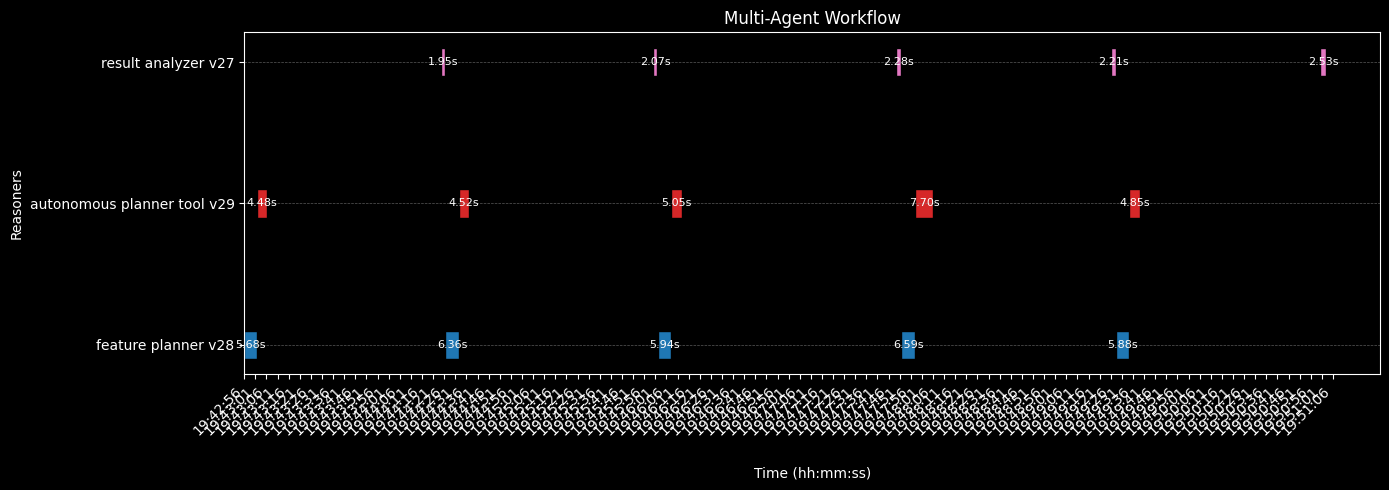

In [111]:
from brain.visualize import plot_workflow_matplotlib
lineage = brain_client.get_call_graph("dc4c1998-f48a-4917-9318-e3602e99e64a")
fig=plot_workflow_matplotlib(lineage['lineage'])